# Curve regression with TensorFlow 2

This ntoebook provides a simple example of performing a regression problem with TensorFlow 2. The notebook could be adapted by changing the fitting functions to address a wide variety of regression tasks.

#### First, import numpy, matplotlib, and tensorflow

Also, check the version of TF.

In [3]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
%matplotlib inline
plt.style.use('..\class14\\astr19-matplotlib-defaults.txt')

#### Second, create a function that will generate some data to fit

In [5]:
#reference function to create the data and make the fit
#first argument is the variable x
#other arguments are amplitude, frequency and phase
def sinsuoid(x, A, f, p):
    return A*np.sin(2.0*np.pi*f *x + p)

In [7]:
#function that will generate some data
def generate_data(xmin=0.0, xmax=10.0, A=1.0, 
                  f=0.5, p=1.0, s=0.25, n=100):
    #xmin is the min of range of the data
    #xmax is the max range of the data
    #A is the asmplitude
    #f is the frequency
    #p is the phse
    #s is the gaussian stdev (for the uncertainty)
    #n is the number of samples

    #create n points randomly (uniformly) distributed between xmin and xmax
    x = np.random.uniform(low=xmin, high=xmax, size=n)
    x = np.asarray(x, dtype=np.float32) #convert to a float

    #y has a value centered on the real curve but with gaussian error
    y = sinsuoid(x, A, f, p) + s*np.random.randn(n)
    y = np.asarray(y, dtype=np.float32) #convert to a float

    y_err = np.full(n, s, dtype=np.float32)

    #return the data
    return x, y, y_err


#### Generate the data

In [32]:
x, y, y_err = generate_data(s=0.05)

#### Plot the data

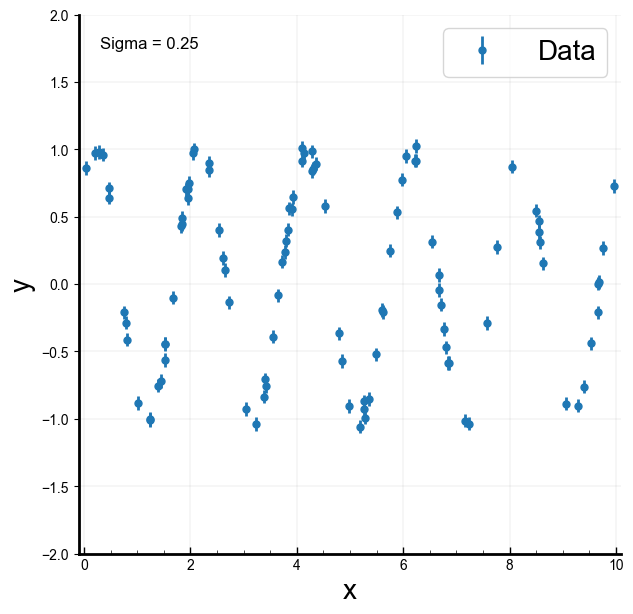

In [22]:
f,ax = plt.subplots(1,1,figsize=(7,7))
ax.errorbar(x,y,y_err,fmt='o',label='Data')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-2.,2.])
ax.text(0.3,1.75,'Sigma = 0.25',color='0',fontsize=12)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=True,fontsize=20,handletextpad=1)
plt.show()

#### Let's prepare our fitted model

First, we declare our fitted variables as global tf.Variables

In [23]:
#Amplitude
A_init = 3.0
A_fit = tf.Variable(A_init, name='amplitude')

#frequency
f_init = 0.5
f_fit = tf.Variable(f_init, name='frequency')

#phase
p_init = 2.0
p_fit = tf.Variable(p_init,name='phase')

#### Now, let's define the model for tensorflow to fit

The function needs to be decorated with the @tf.function decorator.

In [24]:
#define sinusoidal model
@tf.function
def sinusoidal_model(x):
    pi = tf.math.acos(-1.0)
    return A_fit*tf.math.sin(2.0*pi*f_fit*x + p_fit)

#### We need to define the loss function, using tensorflow

We will use mean-squared error

In [25]:
#define loss function
@tf.function
def mse(y_true, y_pred):
    #mse between true and predicted values
    return tf.losses.mean_squared_error(y_true,y_pred)

#### We also need to define the optimizer that tells us how to do gradient descent (derivatives)

We'll use the pre-defined Adam optimizer from Keras.

In [26]:
#Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Now we train the model iteratively

In [27]:
#start training
epochs = 5000 #number of epochs to run
display_step = 1000 #print info every this number of steps

A_array = np.zeros(epochs)
f_array = np.zeros(epochs)
p_array = np.zeros(epochs)
l_array = np.zeros(epochs)

for epoch in range(epochs):

    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = sinusoidal_model(x)
        loss = mse(pred,y)

        #to print this info, we need to convert to numpy arrays
        print(f"Epoch {epoch} : Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p:{p_fit.numpy()}")

    #store values of A, f, p, and loss during the training
    A_array[epoch] = A_fit.numpy()
    f_array[epoch] = f_fit.numpy()
    p_array[epoch] = p_fit.numpy()
    l_array[epoch] = loss.numpy()
    
    #In TF2, gradients are handled using
    #the GradientTape class.
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = sinusoidal_model(x)
        loss = mse(y,pred)

    #compute dm, db, the gradients
    #with respect to (A,f,p)_fit
    gradients = g.gradient(loss, [A_fit,f_fit,p_fit])

    #update (A,f,p)_fit with the gradients x learning
    optimizer.apply_gradients(zip(gradients,[A_fit,f_fit,p_fit]))

#print the last answer
print(f"Epoch {epoch} : Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p:{p_fit.numpy()}")
print("Done!")

Epoch 0 : Loss 3.5883820056915283, A: 3.0 f: 0.5 p:2.0
Epoch 1000 : Loss 0.6481159925460815, A: 2.1400468349456787 f: 0.4920572340488434 p:1.3802802562713623
Epoch 2000 : Loss 0.13033738732337952, A: 1.5203649997711182 f: 0.4981176257133484 p:1.1007773876190186
Epoch 3000 : Loss 0.013987245969474316, A: 1.1539803743362427 f: 0.5000449419021606 p:1.0114774703979492
Epoch 4000 : Loss 0.0029977764934301376, A: 1.0194259881973267 f: 0.5004950165748596 p:0.9899441003799438
Epoch 4999 : Loss 0.0027920794673264027, A: 0.9990160465240479 f: 0.5005539655685425 p:0.9870780110359192
Done!


#### Let's plot the data and the model

In [28]:
x_model = np.linspace(0, 10, 1000)
y_model = sinsuoid(x_model, A_fit, f_fit, p_fit)

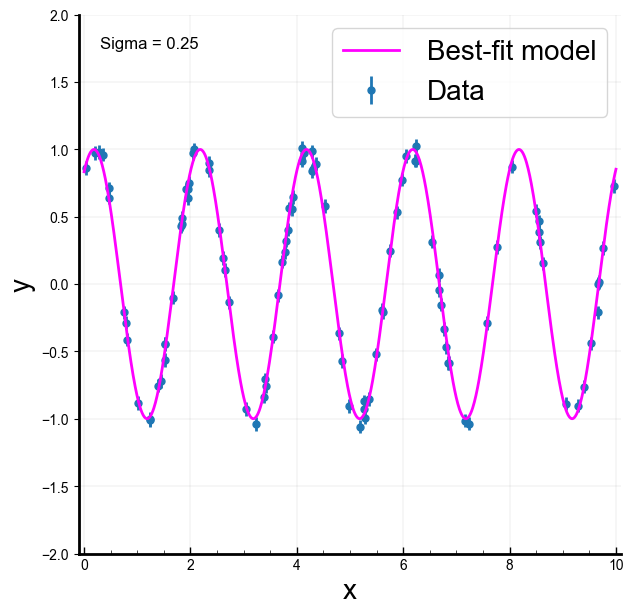

In [29]:
f,ax = plt.subplots(1,1,figsize=(7,7))

ax.errorbar(x,y,y_err,fmt='o', zorder=5, label='Data')
ax.plot(x_model, y_model, color='magenta', zorder=6, label='Best-fit model')

ax.set_xlim([-0.1,10.1])
ax.set_ylim([-2.,2.])
ax.text(0.3,1.75,'Sigma = 0.25',color='0',fontsize=12)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=True,fontsize=20,handletextpad=1)
plt.show()

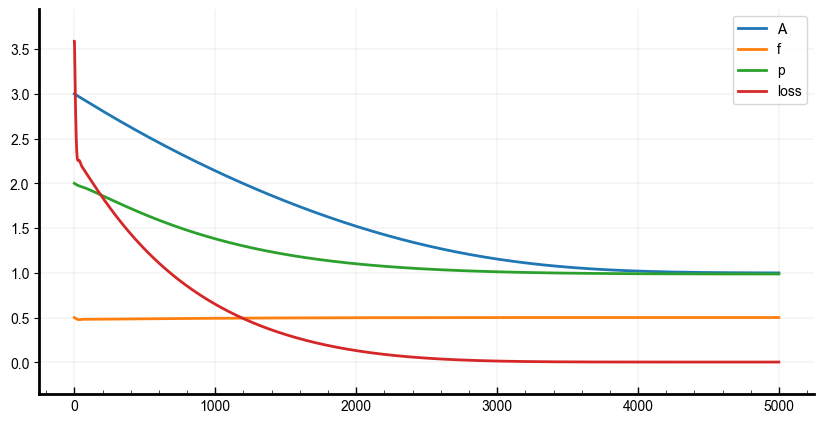

In [30]:
plt.plot(A_array, label='A')
plt.plot(f_array, label='f')
plt.plot(p_array, label='p')
plt.plot(l_array, label='loss')
plt.legend()
plt.show()